# Workbook information

An extension workbook to the Disaster_Tweets project. This includes:

1. Rebuilding, compiling and training models 1, 2 and 5 using Sequential API instead of the Functional API
2. Retrain the baseline model using 10% of the training data - compare the performance to the USE model with 10% of the data
3. Fune-Tune the USE model by setting training = True when instantiating the Keras layer
4. Retrain the best model on the whoile training set (no validation split), then use the model to make rpedictions on teh test dataset and format the predictions into the same format as the `sample_submissions.csv` file from Kaggle. Make a submission to the Kaggle competition
5. COmbine the ensemble predictions using majority vote (mode) - how does it compare to averaging the prediction probabilities of each model?
6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.



# Getting the data

In [1]:
# Importing the helper_functions file
import os

if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/DavAll22/Extra-Code/main/helper_functions_TF.py
else:
  print("[INFO] 'helper_functions_TF.py' already exists, skipping download.")

--2023-06-09 09:43:52--  https://raw.githubusercontent.com/DavAll22/Extra-Code/main/helper_functions_TF.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13751 (13K) [text/plain]
Saving to: ‘helper_functions_TF.py’

helper_functions_TF 100%[===================>]  13.43K  --.-KB/s    in 0s      

2023-06-09 09:43:52 (90.4 MB/s) - ‘helper_functions_TF.py’ saved [13751/13751]



In [2]:
!pip install opendatasets
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
od.download("https://www.kaggle.com/competitions/nlp-getting-started/overview")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: davall22
Your Kaggle Key: ··········


100%|██████████| 593k/593k [00:00<00:00, 735kB/s]


Extracting archive ./nlp-getting-started/nlp-getting-started.zip to ./nlp-getting-started


# Making and exploring the dataset

In [4]:
train_df = pd.read_csv('/content/nlp-getting-started/train.csv')
test_df = pd.read_csv('/content/nlp-getting-started/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffling the data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1, # 10% of training dataset becomes validation dataset
                                                                            random_state=42)

train_sentences.shape, val_sentences.shape, train_labels.shape, val_labels.shape

((6851,), (762,), (6851,), (762,))

# Text Vectorization & Embedding

Text Vectrization --> Turns text into tokens

Embedding --> Turns tokens into a vector

In [7]:
# Setting up text vectorization 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_vocab_length = 10000 
max_length = 15 

text_vectorizer = TextVectorization(max_tokens = max_vocab_length , 
                                    output_mode = 'int', 
                                    output_sequence_length = max_length)

# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

# Creating a embedding layer 
from tensorflow.keras import layers 

embedding = layers.Embedding(input_dim= max_vocab_length , 
                             output_dim = 128 , 
                             embeddings_initializer = 'uniform', 
                             input_length = max_vocab_length)

# 1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using Keras Sequential API

## Model 1

In [8]:
# Building the model 1 (A simple Dense model)
model_1 = tf.keras.Sequential([
    layers.Input(shape = (1, ) , dtype = 'string'), 
    text_vectorizer , 
    embedding , 
    layers.GlobalAveragePooling1D() , 
    layers.Dense(1, activation = 'sigmoid')
    ])
    
# Compiling the model 
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# Fitting the model 
model_1_history =  model_1.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 25s 84ms/step - loss: 0.6139 - accuracy: 0.7005 - val_loss: 0.5416 - val_accuracy: 0.7428
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.4431 - accuracy: 0.8155 - val_loss: 0.4687 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3487 - accuracy: 0.8599 - val_loss: 0.4585 - val_accuracy: 0.7979
Epoch 4/5
215/215 [==============================] - 4s 16ms/step - loss: 0.2856 - accuracy: 0.8895 - val_loss: 0.4682 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2390 - accuracy: 0.9142 - val_loss: 0.4779 - val_accuracy: 0.7874


## Model 2

In [9]:
# Building the model 2 (An LSTM model)
model_2 = tf.keras.Sequential([
    layers.Input(shape = (1, ) , dtype = 'string'), 
    text_vectorizer , 
    embedding , 
    layers.LSTM(64), 
    #layers.GlobalAveragePooling1D() , 
    layers.Dense(1, activation = 'sigmoid')
    ])
    
# Compiling the model 
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# Fitting the model 
model_2_history =  model_1.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2032 - accuracy: 0.9269 - val_loss: 0.4988 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1739 - accuracy: 0.9396 - val_loss: 0.5253 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1506 - accuracy: 0.9475 - val_loss: 0.5514 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1324 - accuracy: 0.9549 - val_loss: 0.5886 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1176 - accuracy: 0.9618 - val_loss: 0.6134 - val_accuracy: 0.7769


## Model 5

In [10]:
# Building the model 5 (Conv1D Model)
model_5 = tf.keras.Sequential([
    layers.Input(shape = (1, ) , dtype = 'string'), 
    text_vectorizer , 
    embedding , 
    layers.Conv1D(32 , 5 , activation= 'relu'),
    layers.GlobalMaxPool1D() , 
    layers.Dense(1, activation = 'sigmoid')
    ])
    
# Compiling the model 
model_5.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# Fitting the model 
model_5_history =  model_1.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1050 - accuracy: 0.9650 - val_loss: 0.6439 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0963 - accuracy: 0.9673 - val_loss: 0.6794 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0875 - accuracy: 0.9718 - val_loss: 0.7145 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0805 - accuracy: 0.9727 - val_loss: 0.7495 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0750 - accuracy: 0.9742 - val_loss: 0.7685 - val_accuracy: 0.7756


# 2. Retrain the baseline model using 10% of the training data. Compare the performance to the USE model with 10% of the data

In [11]:
# Making a better dataset split (no leakage)
train_10_percent_split = int(0.1 * len(train_sentences)) # directly taking 10% from the training data
print(train_10_percent_split)

# Splitting the train data with the actual train data (no double dipping)
train_sentences_10_percent = train_sentences[:train_10_percent_split]

# Repeating with the train labels
train_labels_10_percent = train_labels[:train_10_percent_split]

len(train_labels_10_percent), train_labels_10_percent[:5]

685


(685, array([0, 0, 1, 0, 0]))

In [12]:
# Building a baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
baseline_model = Pipeline([
                  ('tfidf', TfidfVectorizer()), # convert words to numbers using tf-idf
                  ('clf', MultinomialNB()) # model the text
                ])

# Fit the pipeline to the training data
baseline_model.fit(train_sentences_10_percent, train_labels_10_percent)

# Evaluating the baseline model
baseline_score = baseline_model.score(val_sentences, val_labels)
baseline_score

0.7020997375328084

The USE model `model_7` outperforms the baserline on 10% of the training data (77.95% accuracy vs 70.21% accuracy)

# 3. Fine-tune the USE model by setting training=True

In [13]:
# Turn training on to fine-tune the TensorFlow Hub model
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) 

In [14]:
# Create model using the Sequential API
use_model = tf.keras.Sequential([
  sentence_encoder_layer, 
  layers.Dense(1, activation="sigmoid")
])

# Compile model
use_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Train a classifier on top of pretrained embeddings
use_model_history = use_model.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
22/22 [==============================] - 97s 3s/step - loss: 0.6286 - accuracy: 0.6745 - val_loss: 0.5765 - val_accuracy: 0.7467
Epoch 2/5
22/22 [==============================] - 30s 1s/step - loss: 0.4820 - accuracy: 0.8219 - val_loss: 0.5023 - val_accuracy: 0.7782
Epoch 3/5
22/22 [==============================] - 15s 673ms/step - loss: 0.3465 - accuracy: 0.8876 - val_loss: 0.4734 - val_accuracy: 0.7979
Epoch 4/5
22/22 [==============================] - 13s 610ms/step - loss: 0.2085 - accuracy: 0.9533 - val_loss: 0.4818 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 9s 401ms/step - loss: 0.1177 - accuracy: 0.9839 - val_loss: 0.5260 - val_accuracy: 0.7428


# 4. Retraining the best model with the whole training set (no validation split)

Submitting to Kaggle competition

In [15]:
whole_train_sentences = train_df_shuffled['text'].to_numpy()
whole_train_labels =  train_df_shuffled['target'].to_numpy() 

len(whole_train_sentences) , len(whole_train_labels)

(7613, 7613)

In [16]:
# Create model using the Sequential API (model_6)
model = tf.keras.Sequential([
  sentence_encoder_layer, 
  layers.Dense(64 , activation ='relu'),
  layers.Dense(1, activation="sigmoid")
])

# Compile model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Train a classifier on top of pretrained embeddings
model_history =model.fit(whole_train_sentences,
                              whole_train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
238/238 [==============================] - 159s 541ms/step - loss: 0.4164 - accuracy: 0.8239 - val_loss: 0.2647 - val_accuracy: 0.9094
Epoch 2/5
238/238 [==============================] - 31s 131ms/step - loss: 0.2063 - accuracy: 0.9250 - val_loss: 0.0882 - val_accuracy: 0.9764
Epoch 3/5
238/238 [==============================] - 37s 154ms/step - loss: 0.0690 - accuracy: 0.9778 - val_loss: 0.0400 - val_accuracy: 0.9856
Epoch 4/5
238/238 [==============================] - 30s 126ms/step - loss: 0.0427 - accuracy: 0.9865 - val_loss: 0.0223 - val_accuracy: 0.9908
Epoch 5/5
238/238 [==============================] - 26s 108ms/step - loss: 0.0290 - accuracy: 0.9899 - val_loss: 0.0195 - val_accuracy: 0.9908


In [17]:
# Make predictions with the model
pred_probs = model.predict(test_df['text'].to_numpy())

# Convert prediction probs to labels
preds = tf.squeeze(tf.round(pred_probs))
preds = tf.cast(preds , dtype = tf.int32)

102/102 [==============================] - 3s 23ms/step


In [20]:
preds[:20]

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
      dtype=int32)>

Submitting in correct format to Kaggle

In [18]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [19]:
# New dataframe taking the ID index from the test dataset and the predicted target form the model
submission = pd.DataFrame({'id': test_df['id'].values , 
                           'target': (preds.numpy())})
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [21]:
submission.to_csv('submission.csv', index=False)

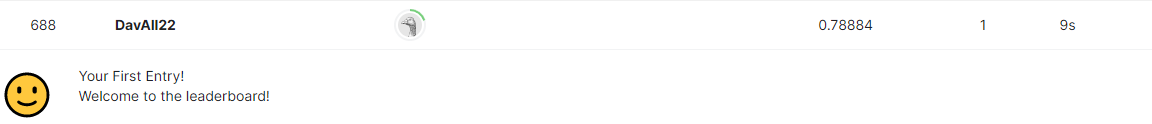

# 5. Combine ensemble predictions using the majority vote (mode)

* `model_5` = Conv1D Model
* `model_2` = LSTM model
* `model` = TFHub USE Model 


In [23]:
# Get predictions for each model
test_sentences = test_df['text'].to_numpy()

test_sentences.shape

(3263,)

In [24]:
# Getting model predictions

def give_preds(model, test_sentences):
  '''
  Take a model and the test sentences as input.
  Returns the prediction array of [0, 1, .....]
  '''
  pred_probs = model.predict(test_sentences)
  preds = tf.squeeze(tf.round(pred_probs))
  preds = tf.cast(preds, dtype=tf.int32)

  return preds

In [25]:
# Getting the predictions for the 3 models 
model_preds = give_preds(model, test_sentences)
model_2_preds = give_preds(model_2 ,test_sentences)
model_5_preds = give_preds(model_5 , test_sentences)

# Checking the shapes of our prediction 
model_preds.shape , model_2_preds.shape , model_5_preds.shape

102/102 [==============================] - 4s 2ms/step


(TensorShape([3263]), TensorShape([3263]), TensorShape([3263]))

In [26]:
model_preds[:5] , model_2_preds[:5] , model_5_preds[:5]

(<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 0, 1, 1], dtype=int32)>)

In [27]:
# Creating a dataframe of our predictions 

preds_df = pd.DataFrame({'USE_model': model_preds , 
              'LSTM_model': model_2_preds , 
              'Conv1D_model': model_5_preds})
preds_df.head()

,USE_model,LSTM_model,Conv1D_model
0,1,1,1
1,1,1,1
2,1,1,0
3,1,1,1
4,1,1,1


In [28]:
# Majority voted predictions of our model
preds_df['majority_vote_preds'] = preds_df.mode(axis = 1)
preds_df.head()

,USE_model,LSTM_model,Conv1D_model,majority_vote_preds
0,1,1,1,1
1,1,1,1,1
2,1,1,0,1
3,1,1,1,1
4,1,1,1,1


In [29]:
# Converting the column into a numpy array 
mode_preds_array = preds_df['majority_vote_preds'].to_numpy()
mode_preds_array

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

# 6. Make a confusion matrix witht he best performing model's predictions on the validation set

best performing model is `model` using USE

In [30]:
# Predictions on the validation sentences 
val_preds = give_preds(model , val_sentences)

# Creating a array of our class names 
class_names = ['not_a_disaster' , 'disaster']

# Checking the preds and true labels shape
val_preds.shape , val_labels.shape

24/24 [==============================] - 0s 9ms/step


(TensorShape([762]), (762,))

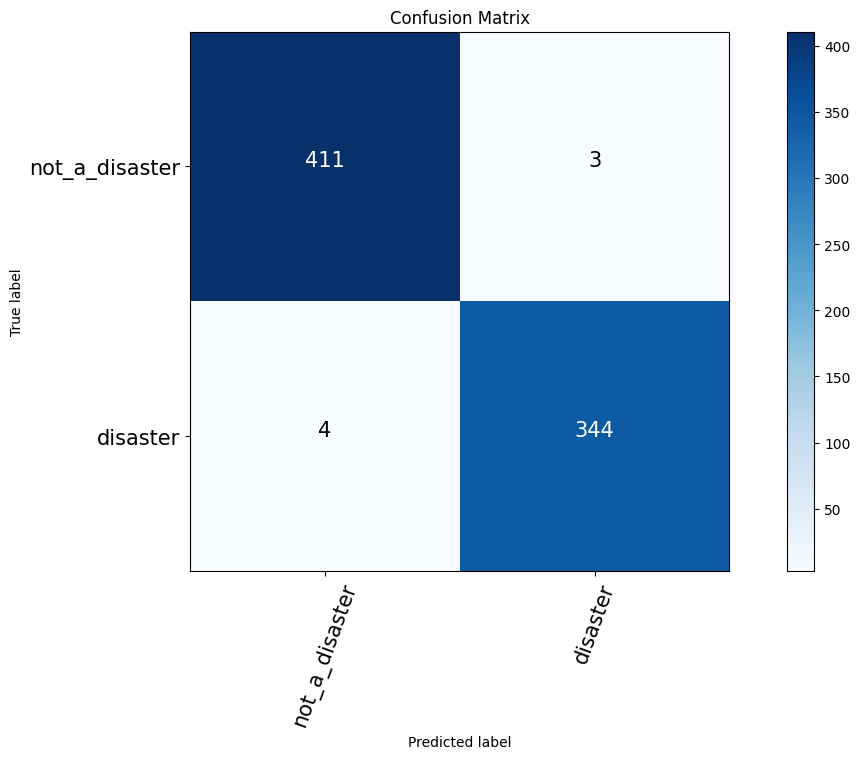

In [31]:
from helper_functions_TF import make_confusion_matrix

# Plotting the confusion matrix 
make_confusion_matrix(y_true= val_labels , 
                      y_pred = val_preds , 
                      classes = class_names , 
                      figsize= (15 , 7), 
                      norm = False , 
                      savefig = True , 
                      text_size = 15)